**Marr–Hildreth algorithm**

# Marr–Hildreth algorithm

Computing the zero-crossings in the LoG-convolved image (to detect edges as a binary image) was proposed by Marr and Hildreth. 
Identification of the edge pixels can be done by viewing the sign of the LoG-smoothed image by defining it as a binary image. 
The algorithm to compute the zero-crossing is as follows:

1. First, convert the LoG-convolved image to a binary image by replacing the pixel values by 1 for positive values and 0 for negative values
2. In order to compute the zero-crossing pixels, we need to simply look at the boundaries of the non-zero regions in this binary image
3. Boundaries can be found by finding any non-zero pixel that has an immediate

The Marr-Hildreth algorithm finds edges in digital images where there are strong and rapid variations in the image brightness. The Marr–Hildreth edge detection method operates by convolving the image with the **Laplacian of the Gaussian** function, or, as a fast approximation by **Difference of Gaussians** (DoG).Then, zero crossings are detected in the filtered result to obtain the edges.

* Steps Involved
   - Apply Gaussian filter to smooth out the image
   - Find zero crossings

# Hough Transform

The Hough transform is a technique which can be used to isolate features of a particular shape within an image. Because it requires that the desired features be specified in some parametric form, the classical Hough transform is most commonly used for the detection of regular curves such as lines, circles, ellipses, etc.


The Hough transform can be used to identify the parameter(s) of a curve which best fits a set of given edge points. This edge description is commonly obtained from a feature detecting operator such as the Roberts Cross, Sobel or Canny edge detector and may be noisy, i.e. it may contain multiple edge fragments corresponding to a single whole feature. Furthermore, as the output of an edge detector defines only where features are in an image, the work of the Hough transform is to determine both what the features are (i.e. to detect the feature(s) for which it has a parametric (or other) description) and how many of them exist in the image.

## The Algorithm
1. Decide on the range of ρ and θ. Often, the range of θ is [ 0, 180 ] degrees and ρ is [ -d, d ] where d is the length of the edge image’s diagonal. It is important to quantize the range of ρ and θ meaning there should be a finite number of possible values.

2. Create a 2D array called the accumulator representing the Hough Space with dimension (num_rhos, num_thetas) and initialize all its values to zero.
3. Perform edge detection on the original image. This can be done with any edge detection algorithm of your choice.
4. For every pixel on the edge image, check whether the pixel is an edge pixel.
  If it is an edge pixel, loop through all possible values of θ, calculate the corresponding ρ, find the θ and ρ index in the accumulator, and increment the accumulator base on those index pairs.
5. Loop through all the values in the accumulator. If the value is larger than a certain threshold, get the ρ and θ index, get the value of ρ and θ from the index pair which can then be converted back to the form of y = ax + b.

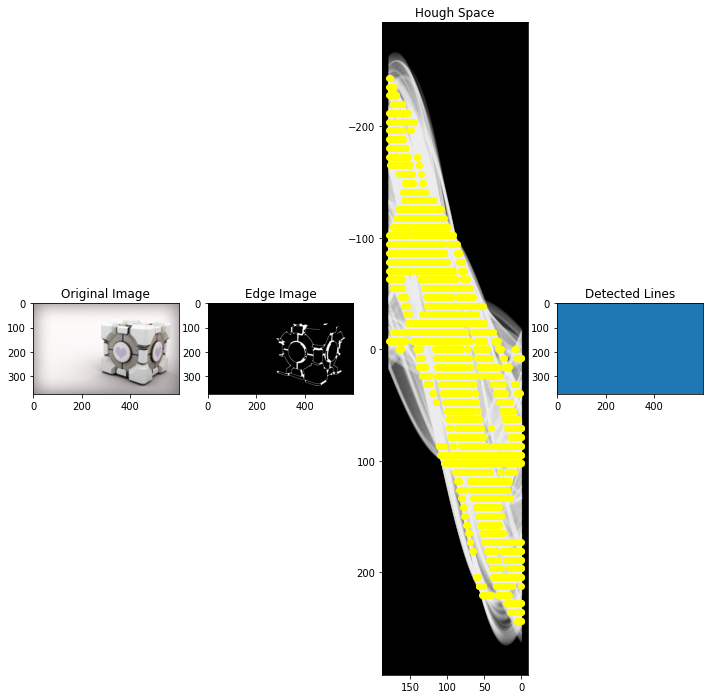

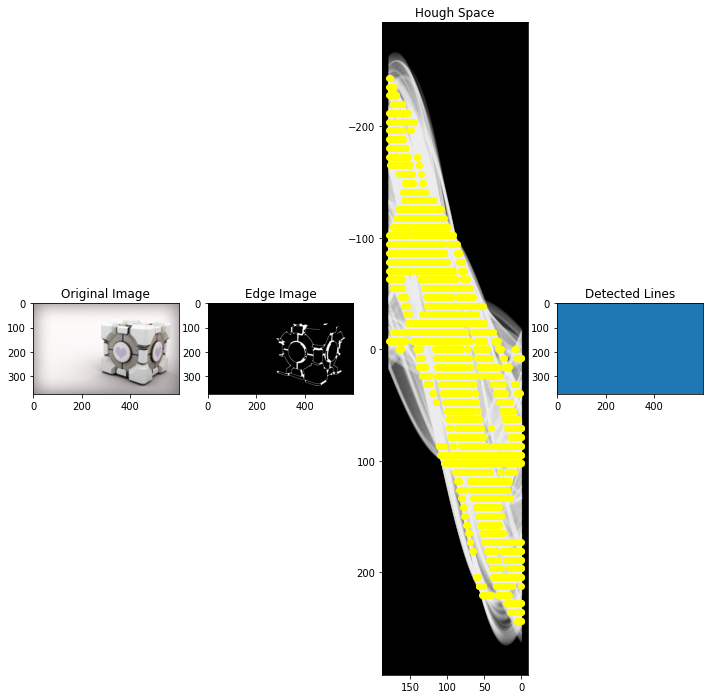

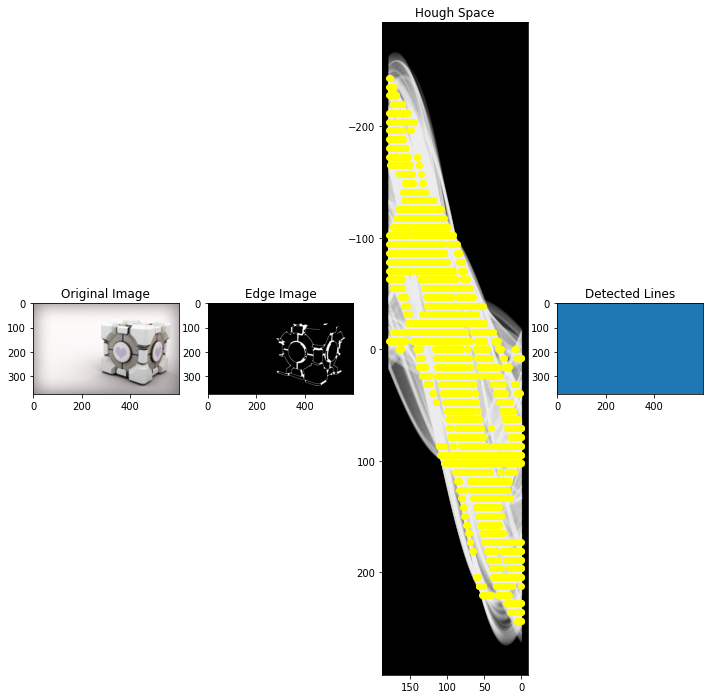

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines


def line_detection_non_vectorized(image, edge_image, num_rhos=180, num_thetas=180, t_count=220):
  edge_height, edge_width = edge_image.shape[:2]
  edge_height_half, edge_width_half = edge_height / 2, edge_width / 2
  #
  d = np.sqrt(np.square(edge_height) + np.square(edge_width))
  dtheta = 180 / num_thetas
  drho = (2 * d) / num_rhos
  #
  thetas = np.arange(0, 180, step=dtheta)
  rhos = np.arange(-d, d, step=drho)
  #
  cos_thetas = np.cos(np.deg2rad(thetas))
  sin_thetas = np.sin(np.deg2rad(thetas))
  #
  accumulator = np.zeros((len(rhos), len(rhos)))
  #
  figure = plt.figure(figsize=(12, 12))
  subplot1 = figure.add_subplot(1, 4, 1)
  subplot1.imshow(image)
  subplot2 = figure.add_subplot(1, 4, 2)
  subplot2.imshow(edge_image, cmap="gray")
  subplot3 = figure.add_subplot(1, 4, 3)
  subplot3.set_facecolor((0, 0, 0))
  subplot4 = figure.add_subplot(1, 4, 4)
  subplot4.imshow(image)
  #
  for y in range(edge_height):
    for x in range(edge_width):
      if edge_image[y][x] != 0:
        edge_point = [y - edge_height_half, x - edge_width_half]
        ys, xs = [], []
        for theta_idx in range(len(thetas)):
          rho = (edge_point[1] * cos_thetas[theta_idx]) + (edge_point[0] * sin_thetas[theta_idx])
          theta = thetas[theta_idx]
          rho_idx = np.argmin(np.abs(rhos - rho))
          accumulator[rho_idx][theta_idx] += 1
          ys.append(rho)
          xs.append(theta)
        subplot3.plot(xs, ys, color="white", alpha=0.05)

  for y in range(accumulator.shape[0]):
    for x in range(accumulator.shape[1]):
      if accumulator[y][x] > t_count:
        rho = rhos[y]
        theta = thetas[x]
        a = np.cos(np.deg2rad(theta))
        b = np.sin(np.deg2rad(theta))
        x0 = (a * rho) + edge_width_half
        y0 = (b * rho) + edge_height_half
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        subplot3.plot([theta], [rho], marker='o', color="yellow")
        subplot4.add_line(mlines.Line2D([x1, x2], [y1, y2]))

  subplot3.invert_yaxis()
  subplot3.invert_xaxis()

  subplot1.title.set_text("Original Image")
  subplot2.title.set_text("Edge Image")
  subplot3.title.set_text("Hough Space")
  subplot4.title.set_text("Detected Lines")
  plt.show()
  return accumulator, rhos, thetas


if __name__ == "__main__":
  for i in range(3):
    image = cv2.imread("/content/cube.jpg")
    edge_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edge_image = cv2.GaussianBlur(edge_image, (3, 3), 1)
    edge_image = cv2.Canny(edge_image, 100, 200)
    edge_image = cv2.dilate(
        edge_image,
        cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)),
        iterations=1
    )
    edge_image = cv2.erode(
        edge_image,
        cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)),
        iterations=1
    )
    line_detection_non_vectorized(image, edge_image)